# Collaborative Filtering Recommender System

## Importing Relevant Packages and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from IPython import display
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
user_artists = pd.read_csv('../data/user_artists_ratings.csv')
user_friends = pd.read_csv('../data/user_friends.csv')
user_taggedartists = pd.read_csv('../data/user_taggedartists.csv')
artists = pd.read_csv('../data/artists.csv')
tags = pd.read_csv('../data/tags.csv')
artists_tags = pd.read_csv('../data/artists_tags.csv')

## Creating Functions to Build Sparse Tensor and Calculate MSE

In [3]:
def build_rating_sparse_tensor(user_artists_df):

    indices = user_artists_df[['userID', 'artistID']].values
    values = user_artists_df['rating'].values

    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[len(user_artists.userID.unique()), artists.shape[0]])

In [4]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):

    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

## Creating Functions to Build a Collaborative-Filtering Model

In [5]:
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
              optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                          end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.set_xlabel("Number of Iterations")
                    ax.set_ylabel("Mean Squared Error")
                    ax.set_title("Training and Testing Errors")
                    ax.legend()
            return results

In [6]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    
    # Split the ratings DataFrame into train and test
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
        'train_error': train_loss,
        'test_error': test_loss
    }
    embeddings = {
        "userID": U,
        "artistID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [7]:
def split_dataframe(df, holdout_fraction=0.1):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

## Building and Training the Model

 iteration 2000: train_error=0.083528, test_error=5.116355

[{'train_error': 0.083528064, 'test_error': 5.116355}]

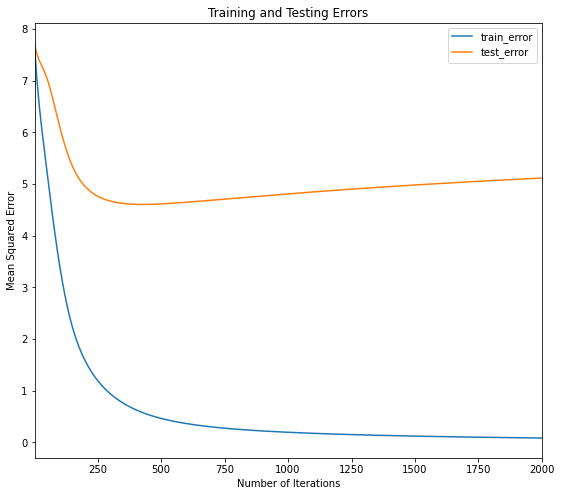

In [8]:
model = build_model(user_artists, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=2000, learning_rate=10.)

 iteration 2000: train_error=3.266350, test_error=5.835364

[{'train_error': 3.26635, 'test_error': 5.8353643}]

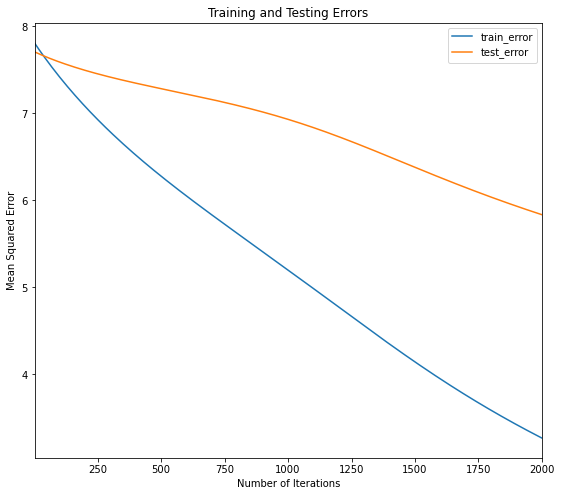

In [9]:
model = build_model(user_artists, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=2000, learning_rate=.5)

 iteration 2000: train_error=0.434694, test_error=3.144789

[{'train_error': 0.43469417, 'test_error': 3.1447892}]

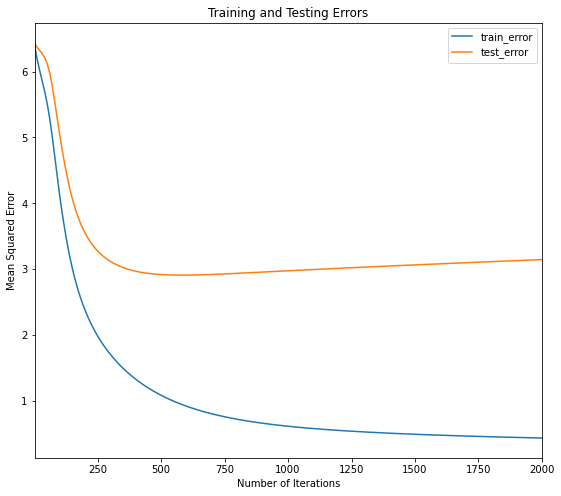

In [10]:
model = build_model(user_artists, embedding_dim=10, init_stddev=0.5)
model.train(num_iterations=2000, learning_rate=10)

# Inspect Embeddings

In [11]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):

    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [12]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
    ids =  artists[artists['name'].str.contains(title_substring)].index.values
    titles = artists.iloc[ids]['name'].values
    if len(titles) == 0:
        raise ValueError("Found no artist with title %s" % title_substring)
    print("Nearest neighbors of : %s." % titles[0])
    if len(titles) > 1:
        print("[Found more than one matching artist. Other candidates: {}]".format(
            ", ".join(titles[1:])))
    artistID = ids[0]
    scores = compute_scores(
        model.embeddings["artistID"][artistID], model.embeddings["artistID"],
        measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'names': artists['name'],
    })
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [13]:
artist_neighbors(model, "Kanye", DOT)

Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,dot score,names
3833,3.895,Bad Boys Blue
3227,3.765,Marillion
257,3.647,Jill Scott
8177,3.606,Axel Fernando
1,3.570,Diary of Dreams
61,3.489,Madonna


In [14]:
artist_neighbors(model, "Kanye", COSINE)

Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,cosine score,names
325,1.000,Kanye West
9110,0.947,Airbag
176,0.931,Keane
2570,0.924,Auto!Automatic!!
683,0.923,Florence + the Machine
5825,0.922,Cash Cash


 iteration 1000: train_error=0.365735, test_error=1.977160Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,dot score,names
325,6.341,Kanye West
300,5.148,Black Eyed Peas
894,4.058,Amy Winehouse
458,3.739,3OH!3
50,3.653,Daft Punk
455,3.374,Miley Cyrus


Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,cosine score,names
325,1.000,Kanye West
11036,0.724,"Eminem feat. Drake, Kanye West, Lil Wayne"
6179,0.683,Lady GaGa Ft. Beyoncé
9154,0.679,Nancy Ajram
277,0.676,Ana Carolina
4606,0.658,John Legend


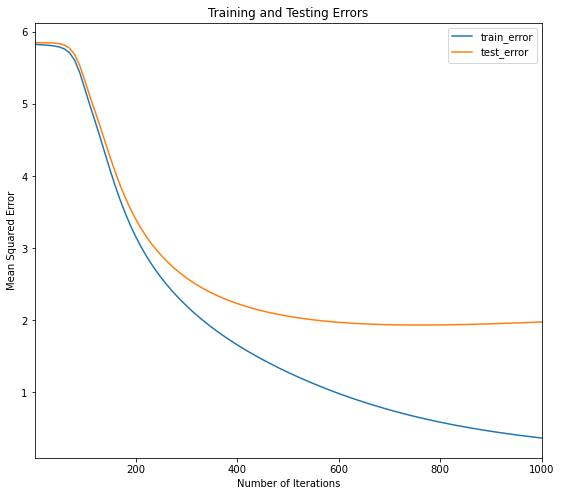

In [15]:
model_lowinit = build_model(user_artists, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
artist_neighbors(model_lowinit, "Kanye", DOT)
artist_neighbors(model_lowinit, "Kanye", COSINE)

In [16]:
def gravity(U, V):
    """Creates a gravity loss given two embedding matrices."""
    return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, 
    embedding_dim=3, 
    regularization_coeff=.1, 
    gravity_coeff=1.,
    init_stddev=0.1):
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

    error_train = sparse_mean_square_error(A_train, U, V)
    error_test = sparse_mean_square_error(A_test, U, V)
    gravity_loss = gravity_coeff * gravity(U, V)
    regularization_loss = regularization_coeff * (
        tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
    total_loss = error_train + regularization_loss + gravity_loss
    losses = {
        'train_error_observed': error_train,
        'test_error_observed': error_test,
    }
    loss_components = {
        'observed_loss': error_train,
        'regularization_loss': regularization_loss,
        'gravity_loss': gravity_loss,
    }
    embeddings = {"userId": U, "artistID": V}

    return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

 iteration 2000: train_error_observed=0.148672, test_error_observed=2.516972, observed_loss=0.148672, regularization_loss=0.467933, gravity_loss=0.192609

[{'train_error_observed': 0.14867209, 'test_error_observed': 2.5169723},
 {'observed_loss': 0.14867209,
  'regularization_loss': 0.46793318,
  'gravity_loss': 0.19260909}]

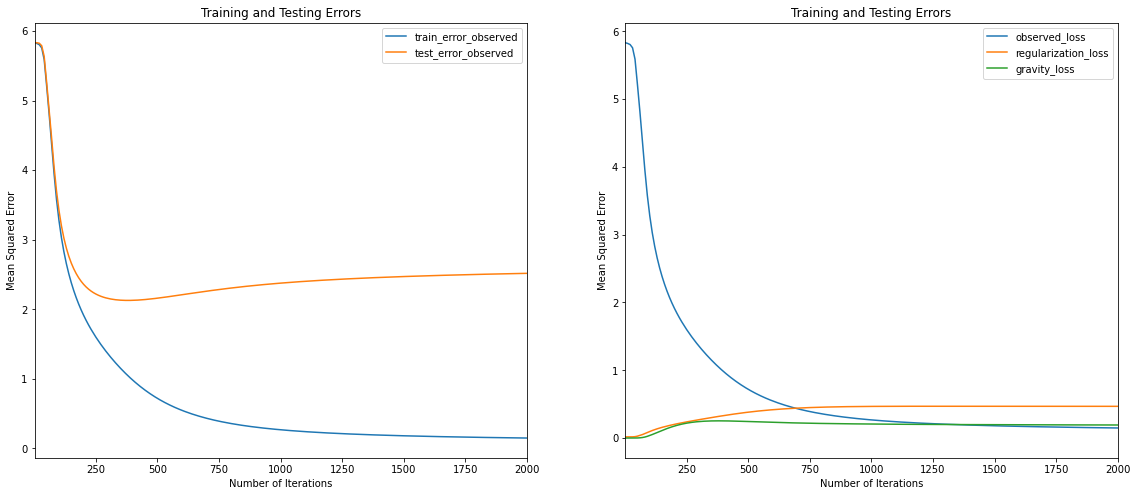

In [17]:
reg_model, u, v = build_regularized_model(
    user_artists, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [19]:
artist_neighbors(reg_model, "Kanye", DOT)
artist_neighbors(reg_model, "Kanye", COSINE)

Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,dot score,names
325,21.095,Kanye West
221,15.184,The Beatles
283,14.188,Britney Spears
294,12.577,Katy Perry
83,11.557,Lady Gaga
228,11.408,Nirvana


Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,cosine score,names
325,1.000,Kanye West
1072,0.687,Ace of Base
1600,0.666,Lykke Li
965,0.659,Amy Studt
11027,0.650,drake and lil wayne
3425,0.650,[unknown]
